# Mitigating Oversmoothing through Structured Graph Randomization

## Project Idea
Oversmoothing (test accuracy) through input graph alteration (structure and node features).

Some parts of the code (i.e. environment set-up, model definitions, training) have been devised throughout the practicals of the Graph Representation Learning module and have been re-used in this project.
Additionally some parts were designed with the help of AI (ChatGPT).

## Set Up Environment and Import Libraries

In [ ]:
# Check PyTorch version installed on this system'
!python -c "import torch; print(torch.__version__)"

2.5.1+cu121


In [ ]:
%%capture
# Download the corresponding PyTorch Geometric module
"""
Assign to TORCH with what you get from the cell above. E.g., export TORCH=1.12.1+cu113
"""
%env TORCH=2.0.1+cu118
!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-geometric

In [ ]:
import torch
import random
import typing
import warnings
import itertools
import collections
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F

import torch_geometric
from sklearn.manifold import TSNE
from torch_geometric.data import Data
import torch_geometric.datasets as datasets
from torch_geometric.loader import DataLoader
from torch_geometric.utils import homophily
from torch_geometric.utils import to_networkx
from torch_geometric.utils import from_networkx
from torch_geometric.nn import Sequential, GCNConv, GATConv

device = torch.device('cpu') # 'cuda' if torch.cuda.is_available() else
warnings.simplefilter(action='ignore', category=FutureWarning)
rng = np.random.default_rng()

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [ ]:
# Setting seeds for reproducibility
# seed_value = 42
# random.seed(seed_value)
# np.random.seed(seed_value)
# torch.manual_seed(seed_value)
# torch.cuda.manual_seed(seed_value)
# torch.cuda.manual_seed_all(seed_value)

## Dataset

---



In [ ]:
# Training Sets, Transformed versions
cora_norm = datasets.Planetoid(root="./", name='Cora', transform=torch_geometric.transforms.GCNNorm()).data

Processing...
Done!
/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


### Dataset Visualisation

In [ ]:
def get_mask_data(data: Data, mask: str="train") -> Data:
  '''Data of specified mask.'''
  if mask == "train":
    m = data.train_mask
  elif mask == "val":
    m = data.val_mask
  elif mask == "test":
    m = data.test_mask
  return m

In [ ]:
def torch_to_networkx(data, undirected=False, mask=None, remove_self_loop=False):
  G = to_networkx(data, to_undirected=undirected, remove_self_loops=remove_self_loop)
  return data, G

In [ ]:
def visualise(data, undirected=False, mask=None, label="class", remove_self_loop=False):
  '''Visualise the data.'''
  data, G = torch_to_networkx(data, undirected, mask, remove_self_loop)

  if label == "class":
    node_labels = data.y.numpy()
  else:
    print("No type of node label specified.")

  plt.figure()
  nx.draw(G, node_size=15, node_color=range(len(node_labels)), cmap=plt.cm.Blues)
  plt.title('Dataset Graph')
  plt.show()

### Degree Exploration

In [ ]:
def degree_sequence(graph):
  '''Degree sequence of the graph.'''
  degree_sequence = sorted((d for n, d in graph.degree()), reverse=True)
  return degree_sequence

In [ ]:
def degree_stats(graph):
  '''Maximum degree of the graph.'''
  max_degree = max(degree_sequence(graph))
  min_degree = min(degree_sequence(graph))
  avg_degree = sum(degree_sequence(graph)) / len(degree_sequence(graph))
  return max_degree, min_degree, avg_degree

In [ ]:
def degree_distribution(dataset: Data, undirected=False, mask=None):
  '''Degree distribution of the dataset.'''

  if mask == None:
    data = dataset.data
  else:
    data = get_mask_data(dataset, mask)
  G = to_networkx(data, to_undirected=undirected)

  deg_sequence = degree_sequence(G)
  plt.bar(*np.unique(deg_sequence, return_counts=True))
  plt.title("Degree histogram")
  plt.xlabel("Degree")
  plt.ylabel("# of Nodes")
  plt.show()

## Dataset Manipulations (Training Set)


### Helper Functions

In [ ]:
def get_num_classes(data: Data) -> int:
  '''Number of classes in the dataset.'''
  num_classes = data.y.max().item() + 1
  return num_classes

In [ ]:
def data_info(data, undirected=False, mask=None, self_loop=False):
  '''Information about the dataset.'''
  data, graph = torch_to_networkx(data, undirected, mask, self_loop)
  print(f'Isolated nodes: {data.has_isolated_nodes()}')
  print(f'Self-loops: {data.has_self_loops()}')
  print(f'Undirected: {data.is_undirected()}')
  print(f'Maximum degree: {degree_stats(graph)[0]}')
  print(f'Minimum degree: {degree_stats(graph)[1]}')
  print(f'Average degree: {degree_stats(graph)[2]}')

In [ ]:
def get_node_split_prop(data: Data, values: bool=False) -> None:
  '''Nodes in each of the split sets either as proportion or the actual values.'''
  masks = ["train", "val", "test"]
  all_values = [get_mask_data(data,m).sum().item() for m in masks]
  if values:
    result = all_values
  else:
    result = [round(v / data.num_nodes, 3) for v in all_values]
  return (result[0], result[1], result[2])

In [ ]:
def get_data(data: Data, mask: str="train") -> tuple[torch.Tensor, torch.Tensor]:
  '''X and Y of data split specified.'''
  m = get_mask_data(data, mask)
  x, y = data.x[m], data.y[m]
  return x, y

In [ ]:
def get_edge_mask(data: Data, mask: str="train") -> torch.BoolTensor:
  '''Boolean tensor of size number of edges of data.edge_index
  indicating whether edge (column) is in split set or not.'''
  m = get_mask_data(data, mask)
  edge_mask = (m[data.edge_index[0]] | m[data.edge_index[1]])
  # edge_mask = torch.tensor([1 if mask[e_idx[0,i]] or mask[e_idx[1,i]] else 0 for i in range(data.num_edges)])
  return edge_mask

In [ ]:
def get_train_edges(data: Data) -> torch.Tensor:
  '''Edge_index of all edges in the training set.'''
  train_edge_mask = get_edge_mask(data, "train")
  train_edge_index = data.edge_index[:, train_edge_mask]
  return train_edge_index

In [ ]:
def get_num_edges(data: Data, mask: str="train") -> int:
  '''Number of edges in the specified set.'''
  num_edges = get_edge_mask(data, mask).sum().item()
  return num_edges

In [ ]:
def get_num_nodes(data: Data, mask: str="train") -> int:
  '''Number of nodes in the specified set.'''
  num_nodes = get_mask_data(data, mask).sum().item()
  return num_nodes

In [ ]:
def get_edge_split_prop(data: Data, values: bool=False) -> None:
  '''Edges in each of the split sets either as proportion or the actual values.'''
  masks = ["train", "val", "test"]
  all_values = [get_num_edges(data, m) for m in masks]
  if values:
    result = all_values
  else:
    result = [round(v / data.num_nodes, 3) for v in all_values]
  return (result[0], result[1], result[2])

In [ ]:
def stratified_sample(num: int, num_classes: int) -> list:
  '''Stratified sample sizes per classes.'''
  if num < num_classes:
    sample_sizes = [1 if i < num else 0 for i in range(num_classes)]
  else:
    base_samples = num // num_classes
    remainder = num % num_classes
    sample_sizes = [base_samples] * num_classes
    for i in range(remainder):
      sample_sizes[i] += 1

  random.shuffle(sample_sizes)
  return sample_sizes

In [ ]:
def nodes_per_class(data: Data, mask: str="train") -> None:
  '''Number of nodes per class in the training set.'''
  m = get_mask_data(data, mask)
  x_train, y_train = get_data(data, mask)
  nodes = torch.nonzero(m).flatten().tolist()
  class_nodes = {}
  for n in nodes:
    label = data.y[n].item()
    if label not in class_nodes:
        class_nodes[label] = []
    class_nodes[label].append(n)
  class_nodes = {key: class_nodes[key] for key in sorted(class_nodes.keys())}
  return class_nodes

In [ ]:
def drop_nodes_from_data(data: Data, node_list: list) -> Data:
  '''Drop list of nodes from x.'''
  mask = torch.ones(data.x.size(0), dtype=torch.bool)
  mask[node_list] = False
  data.x = data.x[mask]
  data.y = data.y[mask]
  data.train_mask = data.train_mask[mask]
  data.val_mask = data.val_mask[mask]
  data.test_mask = data.test_mask[mask]

  return data

In [ ]:
def drop_edges_of_node(data: Data, node: int) -> Data:
  '''Drop all edges from edge_index incident to given node.'''
  drop_mask = (data.edge_index[0] != node) & (data.edge_index[1] != node)
  data.edge_index = data.edge_index[:, drop_mask]
  return data

In [ ]:
def drop_edges_from_index(data: Data, edges: torch.Tensor) -> Data:
  '''Drop edges from edge_index.'''
  edges_to_remove_set = {tuple(edge.tolist()) for edge in edges}
  drop_mask = torch.tensor([tuple(edge.tolist()) not in edges_to_remove_set for edge in data.edge_index.t()])
  data.edge_index = data.edge_index[:, drop_mask]
  return data

In [ ]:
def node_degree(data: Data, node: int) -> int:
  '''Degree of a node.'''
  degree = data.edge_index.flatten().tolist().count(node)
  return degree

In [ ]:
def dataset_overview(data: list, data_names: list):
  '''Information of the datasets.'''
  info_labels = ["Dataset", "Number of nodes", "Number of edges", "Number of classes",
                 "Number of features", "Isolated nodes", "Self-loops", "Undirected",
                 "Maximum degree", "Minimum degree", "Average degree", "Nodes Train/Val/Test",
                 "Edges Train/Val/Test", "Edge Homophily", "Node Homophily"]

  graphs = [torch_to_networkx(d)[1] for d in data]

  isolated = [d.has_isolated_nodes() for d in data]
  self_loops = [d.has_self_loops() for d in data]
  undirected = [d.is_undirected() for d in data]
  max_degree = [degree_stats(g)[0] for g in graphs]
  min_degree = [degree_stats(g)[1] for g in graphs]
  avg_degree = [degree_stats(g)[2] for g in graphs]
  num_classes = [get_num_classes(d) for d in data]
  num_nodes = [d.num_nodes for d in data]
  num_edges = [d.num_edges for d in data]
  num_feats = [d.x.shape[1] for d in data]
  edge_split = [get_edge_split_prop(d, True) for d in data]
  node_split = [get_node_split_prop(d, True) for d in data]
  edge_homo = [homophily(d.edge_index, d.y, method='edge') for d in data]
  node_homo = [homophily(d.edge_index, d.y, method='node') for d in data]

  info = [data_names, num_nodes, num_edges, num_classes, num_feats, isolated, self_loops,
        undirected, max_degree, min_degree, avg_degree, node_split, edge_split, edge_homo, node_homo]
  data_for_df = {info_labels[i]: info[i] for i in range(len(info))}
  data_frame = pd.DataFrame(data_for_df)

  return data_frame

In [ ]:
print(dataset_overview([cora_norm], ['Cora Normalized']).to_latex())

\begin{tabular}{llrrrrrrrrrrllrr}
\toprule
 & Dataset & Number of nodes & Number of edges & Number of classes & Number of features & Isolated nodes & Self-loops & Undirected & Maximum degree & Minimum degree & Average degree & Nodes Train/Val/Test & Edges Train/Val/Test & Edge Homophily & Node Homophily \\
\midrule
0 & Cora Normalized & 2708 & 10556 & 7 & 1433 & False & False & True & 336 & 2 & 7.796160 & (140, 500, 1000) & (1234, 3478, 6118) & 0.809966 & 0.825158 \\
\bottomrule
\end{tabular}



### Main Functions

#### Structural Change
* Drop edges
* Rewire edges (add self loops)

In [ ]:
def drop_edges_train(data: Data, prop_drop_edges: float = 0.0) -> Data: # some could be isolated
  '''Randomly drops a proportion of edges in the training set.'''
  # remove edges from dropout_edge, mask_to_index, mask_feature

  num_edges_train = get_num_edges(data)
  num_edge_drop = int(prop_drop_edges * num_edges_train)

  if num_edge_drop:
    train_edge_index = get_train_edges(data)
    rnd_edge_idxs = torch.randperm(num_edges_train)[:num_edge_drop]
    edges_to_remove = [train_edge_index[:, i] for i in rnd_edge_idxs]
    data = drop_edges_from_index(data, edges_to_remove)
  else:
    data = cora_norm

  return data

In [ ]:
def rewire_edges_train(data: Data, prop_rewire_edges: float = 0.0) -> Data:
  '''Randomly rewire edges in the training set.'''
  num_nodes = data.num_nodes
  num_nodes_train = get_num_nodes(data)
  num_edges_train = get_num_edges(data)
  num_edges_rewire = int(prop_rewire_edges * num_edges_train)
  train_edge_mask = get_edge_mask(data)

  if num_edges_rewire:
    train_edge_index = get_train_edges(data)
    rewire_idxs = torch.randint(0, num_edges_train, (num_edges_rewire,))
    node_rewire = torch.randint(0, num_nodes_train, (num_edges_rewire,))
    for i in range(num_edges_rewire):
      row = random.choice([0, 1])
      train_edge_index[row, rewire_idxs[i]] = node_rewire[i]

    true_indices = train_edge_mask.nonzero(as_tuple=True)[0]
    for i in range(num_edges_train):
      data.edge_index[0,true_indices[i]] = train_edge_index[0,i]
      data.edge_index[1,true_indices[i]] = train_edge_index[1,i]
  else:
    data = cora_norm

  return data

#### Node Feature Change
* Shuffle node embeddings across nodes
* Shuffle node embeddings within vectors
* (Reweight edges to 0 or else)

In [ ]:
def shuffle_vectors_feats(data: Data, prop_shuffle_feats: float = 0.0) -> Data:
  '''Shuffle node embeddings within vectors.'''
  num_nodes_train = get_num_nodes(data)
  num_vect_shuffle = int(prop_shuffle_feats * num_nodes_train)

  if num_vect_shuffle:
    train_nodes = torch.nonzero(data.train_mask).flatten()
    nodes_to_shuffle = random.sample(train_nodes.tolist(), num_vect_shuffle)
    selected_features = data.x[nodes_to_shuffle]
    shuffled_features = torch.stack([row[torch.randperm(row.size(0))] for row in selected_features])
    data.x[nodes_to_shuffle] = shuffled_features
  else:
    data = cora_norm
  return data

In [ ]:
def shuffle_node_feats(data: Data, prop_shuffle_nodes: float = 0.0) -> Data:
  '''Shuffle node embeddings across nodes of a same class.'''
  num_classes = get_num_classes(data)
  num_nodes_train = get_num_nodes(data)
  num_nodes_shuffle = int(prop_shuffle_nodes * num_nodes_train)

  num_node_class = int(num_nodes_shuffle / num_classes)
  size_per_class = stratified_sample(num_nodes_shuffle, num_classes)
  dict_node_class = nodes_per_class(data)

  if num_nodes_shuffle:
    i = 0
    for label, nodes_in_class in dict_node_class.items():
      num_nodes_to_shuffle = min(size_per_class[i], len(nodes_in_class))
      nodes_to_shuffle = random.sample(nodes_in_class, num_nodes_to_shuffle)
      pair_node = random.sample(nodes_in_class, num_nodes_to_shuffle)
      for (x,y) in zip(nodes_to_shuffle, pair_node):
        data.x[x], data.x[y] = data.x[y].clone(), data.x[x].clone()
      i += 1
  else:
    data = cora_norm
  return data

#### Combine Structural and Feature Changes

In [ ]:
def structural_change(data: Data, prop_drop_edges: float, prop_drop_nodes: float, prop_rewire_edges: float, prop_shuffle_feats: float, prop_shuffle_nodes: float) -> Data:
  data = drop_edges_train(data, prop_drop_edges)
  data = rewire_edges_train(data, prop_rewire_edges)
  data = shuffle_vectors_feats(data, prop_shuffle_feats)
  data = shuffle_node_feats(data, prop_shuffle_nodes)
  return data

In [ ]:
def change_dataset_prop_range(data, range, type):
  data_list = []
  for prop in range:
    test_data = data.clone()
    if type == "drop_edges":
      new_data = drop_edges_train(test_data, prop)
    elif type == "rewire_edges":
      new_data = rewire_edges_train(test_data, prop)
    elif type == "shuffle_feats":
      new_data = shuffle_vectors_feats(test_data, prop)
    elif type == "shuffle_nodes":
      new_data = shuffle_node_feats(test_data, prop)
    data_list.append(new_data)
  return data_list

### Dataset Exploration


In [ ]:
def all_degree_distribution(data):
  '''Degree distribution of the dataset.'''
  data, G = torch_to_networkx(data)
  deg_sequence = degree_sequence(G)
  plt.bar(*np.unique(deg_sequence, return_counts=True))
  plt.xlabel("Degree")
  plt.ylabel("# of Nodes")

In [ ]:
def all_degree_plot(data_list, data_names_list):
  '''Degree distribution of the dataset.'''
  fig, axes = plt.subplots(1, len(data_list), figsize=(18, 5))
  for i, (d, name) in enumerate(zip(data_list, data_names_list)):
      plt.sca(axes[i])
      all_degree_distribution(d)
      plt.title(f"Degree distribution of {name}")
  plt.tight_layout()
  plt.show()

In [ ]:
# AI helped
def node_class_distribution(data_list, data_names_list):
  '''Class distribution of the dataset.'''
  fig, axes = plt.subplots(1, 4, figsize=(18, 6))
  for i, (d, name) in enumerate(zip(data_list, data_names_list)):
      plt.sca(axes[i])
      counter = collections.Counter(d.y.numpy())
      counter = dict(counter)
      count = [x[1] for x in sorted(counter.items())]
      print(count)
      plt.bar(range(len(count)), count)
      plt.xlabel("Class", size=20)
      plt.ylabel("# of Nodes", size=20)
      plt.title(f"Nodes per class for {name}")
  plt.tight_layout()
  plt.show()

In [ ]:
# https://medium.com/@koki_noda/ultimate-guide-to-graph-neural-networks-1-cora-dataset-37338c04fe6f
def split_type_plot(data):
  split_type_array = 1*data.train_mask.numpy() + 2*data.val_mask.numpy() + 3*data.test_mask.numpy()
  plt.scatter(range(data.num_nodes), split_type_array)
  plt.xlabel("index")
  plt.show()

In [ ]:
# AI helped
def bar_plot_node_split(data):
  split_type_array = 1*data.train_mask.numpy() + 2*data.val_mask.numpy() + 3*data.test_mask.numpy()
  titles = ["Training", "Validation", "Test"]
  fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
  for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
    # plt.figure(figsize=(10, 6))
    axes[i].bar(range(get_num_classes(data)), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
  plt.tight_layout()
  plt.show()

### Data Randomization

#### Cora Data Randomization

In [ ]:
props = [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

In [ ]:
# CoraNorm
data_drop_edges = change_dataset_prop_range(cora_norm, props, "drop_edges")
data_rewire_edges = change_dataset_prop_range(cora_norm, props, "rewire_edges")
data_shuffle_within = change_dataset_prop_range(cora_norm, props, "shuffle_feats")
data_shuffle_across = change_dataset_prop_range(cora_norm, props, "shuffle_nodes")

## Model Set-Up for Evaluation
* Define several model architectures (as found in papers of interest) with number of layers as parameter
* Initialize, train and test accuracy
  * Modelize accuracy per number of layers per model for each dataset

### Model Definitions

In [ ]:
# GRL Practical
class GCN(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(GCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio

    if n_layers == 0:
      self.lin = nn.Linear(input_dim, n_classes)
      self.gcn = None # if no gcn
    else:
      layers = []
      layers.append(GCNConv(input_dim, hid_dim)) # first layer
      for i in range(n_layers - 1): # hidden layers
        layers.append(GCNConv(hid_dim, hid_dim))
      self.gcn = nn.ModuleList(layers)
      self.lin = nn.Linear(hid_dim, n_classes) # only last linear layer

  def forward(self, X, A) -> torch.Tensor:
    if self.gcn:
      for layer in self.gcn:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=self.training) # only during training
    X = self.lin(X) # not on last layer activation function
    return X # last layer representation

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    with torch.no_grad():
      return self.forward(X,A)

  def param_init(self):
    nn.init.uniform_(self.lin.weight, a=-0.1, b=0.1)
    if self.lin.bias is not None:
      nn.init.uniform_(self.lin.bias, a=-0.1, b=0.1)
    if self.gcn:
      for layer in self.gcn:
        nn.init.uniform_(layer.lin.weight, a=-0.1, b=0.1)
        if layer.lin.bias is not None:
          nn.init.uniform_(layer.lin.bias, a=-0.1, b=0.1)

In [ ]:
# GRL Practical
class SkipGCN(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(SkipGCN, self).__init__()
    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.hid_dim = hid_dim

    if n_layers == 0:
      self.lin = nn.Linear(input_dim, n_classes)
      self.gcn = None
    else:
      layers = []
      layers.append(GCNConv(input_dim, hid_dim))
      for i in range(n_layers - 1):
        layers.append(GCNConv(hid_dim, hid_dim))
      self.gcn = nn.ModuleList(layers)
      self.lin = nn.Linear(hid_dim, n_classes)

  def forward(self, X, A) -> torch.Tensor:
    output = torch.zeros(self.hid_dim) if self.gcn else X
    if self.gcn:
      for layer in self.gcn:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=self.training)
        output = output + X # add residuals
    X = self.lin(output)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    output = torch.zeros(self.hid_dim) if self.gcn else X
    if self.gcn:
      for layer in self.gcn:
        X = layer(X, A)
        X = F.relu(X)
        output = output + X
      X = output
    return X

  def param_init(self):
    nn.init.uniform_(self.lin.weight, a=-0.1, b=0.1)
    if self.lin.bias is not None:
      nn.init.uniform_(self.lin.bias, a=-0.1, b=0.1)

    if self.gcn:
      for layer in self.gcn:
        nn.init.uniform_(layer.lin.weight, a=-0.1, b=0.1)
        if layer.lin.bias is not None:
          nn.init.uniform_(layer.lin.bias, a=-0.1, b=0.1)

In [ ]:
# GRL Practical
class JumpKnowGCN(nn.Module):
  def __init__(self, input_dim: int, hid_dim: int, n_classes: int, n_layers: int, dropout_ratio: float = 0.3):
    super(JumpKnowGCN, self).__init__()

    """
    Args:
      input_dim: input feature dimension
      hid_dim: hidden feature dimension
      n_classes: number of target classes
      n_layers: number of layers
      dropout_ratio: dropout_ratio
    """
    self.n_layers = n_layers
    self.dropout_ratio = dropout_ratio
    self.hid_dim = hid_dim

    if n_layers == 0:
      self.lin = nn.Linear(input_dim, n_classes)
      self.gcn = None
    else:
      layers = []
      layers.append(GCNConv(input_dim, hid_dim))
      for i in range(n_layers - 1):
        layers.append(GCNConv(hid_dim, hid_dim))
      self.gcn = nn.ModuleList(layers)
      self.lin = nn.Linear(hid_dim, n_classes)

  def forward(self, X, A) -> torch.Tensor:
    output = []
    if self.gcn:
      for layer in self.gcn:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=self.training)
        output.append(X)
      X = torch.stack(output).max(dim=0).values
    X = self.lin(X)
    return X

  def generate_node_embeddings(self, X, A) -> torch.Tensor:
    output = []
    if self.gcn:
      for layer in self.gcn:
        X = layer(X, A)
        X = F.relu(X)
        X = F.dropout(X, self.dropout_ratio, training=self.training)
        output.append(X) # changed to add connection from layers to last layers
      X = torch.stack(output).max(dim=0).values
    return X

  def param_init(self):
    nn.init.uniform_(self.lin.weight, a=-0.1, b=0.1)
    if self.lin.bias is not None:
      nn.init.uniform_(self.lin.bias, a=-0.1, b=0.1)

    if self.gcn:
      for layer in self.gcn:
        nn.init.uniform_(layer.lin.weight, a=-0.1, b=0.1)
        if layer.lin.bias is not None:
          nn.init.uniform_(layer.lin.bias, a=-0.1, b=0.1)

### Model Helper Functions

In [ ]:
# GRL Practical
def evaluate(model, data, mask):
   model.eval()
   with torch.no_grad():
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    correct = (pred[mask]==data.y[mask]).sum().item()
    accuracy = correct / mask.sum().item()
   return accuracy

In [ ]:
# GRL Practical
def train(params: typing.Dict, data: Data) -> torch.nn.Module:
  '''This function trains a node classification model and returns the trained model object.'''
  # Set device
  device = "cpu"  if torch.cuda.is_available() else "gpu"
  # Load dataset
  data = data.to(device)
  # Update parameters
  params["n_classes"] = get_num_classes(data)
  params["input_dim"] = data.num_features

  # Set a model
  if params['model_name'] == 'GCN':
      model = GCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
        ).to(device)
  elif params['model_name'] == 'SkipGCN':
      model = SkipGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  elif params['model_name'] == 'JumpKnowGCN':
      model = JumpKnowGCN(
        params["input_dim"],
        params["hid_dim"],
        params["n_classes"],
        params["n_layers"]
      ).to(device)
  else:
      raise NotImplementedError
  model.param_init()

  optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
  loss_fn = nn.CrossEntropyLoss()
  train_losses, train_accuracies, test_accuracies = [],[],[]
  patience = params['max_patience']
  prev_acc = 0
  patience_count = 0
  best_val = 0
  best_test = 0
  for epoch in range(params['epochs']):
    if patience_count==patience:
      break
    model.train()
    optimizer.zero_grad()
    loss = 0
    y_pred = model(data.x, data.edge_index)
    loss = loss_fn(y_pred[data.train_mask], data.y[data.train_mask])
    train_losses.append(loss)
    _, predicted = torch.max(y_pred.data, 1)

    train_acc = sum(predicted[data.train_mask]==data.y[data.train_mask]).item()/len(data.y[data.train_mask])
    train_accuracies.append(train_acc)
    test_acc = evaluate(model, data, data.test_mask)
    best_test = max(best_test, test_acc)
    val_acc = evaluate(model, data, data.val_mask)

    if val_acc <= prev_acc:
      patience_count += 1
    else:
      prev_acc = val_acc
      patience_count = 0

    best_val = max(best_val, val_acc)
    test_accuracies.append(test_acc)

    loss.backward()
    optimizer.step()

  return (model, params["n_layers"], best_val, best_test, epoch)

In [ ]:
def average_best_model(params, data, num):
  '''This function trains a node classification model and returns the trained model object.'''
  best_tests = []
  for i in range(num):
    model, n_layers, best_val, best_test, epoch = train(params, data)
    best_tests.append(best_test)
  avg_best = sum(best_tests)/len(best_tests)
  return avg_best

In [ ]:
def train_layer_range(params: typing.Dict, data: Data, layer_range: list, num: int) -> torch.nn.Module:
  '''Train model for different number of layers.'''
  best_test = []
  for n_layers in layer_range:
    params["n_layers"] = n_layers
    result = average_best_model(params, data, num)
    best_test.append(result)
  return best_test

In [ ]:
def draw_performance_per_layer(dataframe):
  plt.figure(figsize=(10, 6))
  for column in dataframe.columns:
      plt.plot(dataframe.index, dataframe[column], label=column, marker='o')
  plt.xlabel('Layers')
  plt.ylabel('Values')
  plt.title('Values vs Layers for Different Shuffled Values')
  plt.legend()
  plt.grid(True)
  plt.show()

#### Parameters

In [ ]:
layers = [0, 1, 2, 3, 4, 8, 12]
num_evaluations = 5

In [ ]:
training_params_gcn = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 75,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # None, # number of layers
    "model_name": "GCN"
}

In [ ]:
training_params_skip = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 75,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "SkipGCN"
}

In [ ]:
training_params_jump = {
    "lr": 0.005,  # learning rate
    "weight_decay": 0.0005,  # weight_decay
    "epochs": 75,  # number of total training epochs
    "max_patience": 5, # number of k for early stopping
    "hid_dim": 64, # size of hidden features
    "n_layers": None, # number of layers
    "model_name": "JumpKnowGCN"
}

In [ ]:
all_train_params = [training_params_gcn, training_params_skip, training_params_jump]

In [ ]:
def data_results(data: Data, type: str, num: int) -> pd.DataFrame:
  '''Train model for different number of layers and different models.'''
  result_dfs = {}
  for params in all_train_params:
    result = {}
    for (i,j) in zip(data, props):
      models = train_layer_range(params, i, layers, num)
      result[f'{j} {type}'] = models
    result_dfs[f'{params["model_name"]}'] = pd.DataFrame(result, index=[l for l in layers])
  return result_dfs

In [ ]:
def save_df(result_dfs: pd.DataFrame, typ: str):
  cols = [f'0.0 {typ}', f'0.01 {typ}', f'0.05 {typ}', f'0.1 {typ}', f'0.2 {typ}', f'0.3 {typ}', f'0.5 {typ}']
  for k, v in result_dfs.items():
    df = pd.DataFrame(v)
    df.to_csv(f'{k}_{typ}.csv', index=False, columns=cols)

## Cora Norm

In [ ]:
drop_edge = data_results(data_drop_edges, "drop_edges", num_evaluations)
save_df(drop_edge, "drop_edges")

In [ ]:
rewire_edge = data_results(data_rewire_edges, "rewire_edges", num_evaluations)
save_df(rewire_edge, "rewire_edges")

In [ ]:
shuffle_within = data_results(data_shuffle_within, "shuffle_within", num_evaluations)
save_df(shuffle_within, "shuffle_within")

In [ ]:
shuffle_across = data_results(data_shuffle_across, "shuffle_across", num_evaluations)
save_df(shuffle_across, "shuffle_across")

### Additional Hyperparameter Exploration

In [ ]:
# layers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
# num_evaluations = 10
data = {
    'Eval': [10, 10, 10],
    'Epochs': [100, 100, 100],
    'Layers': [13, 13, 13],
    'HiddenDim': [16, 32, 64],
    'LRate': [0.01, 0.005, 0.001],
    'Dropout': [0.5, 0.3, 0.3],
}

# Define custom column names and index
columns = ['Eval', 'Epochs', 'Layers', 'HiddenDim', 'LRate', 'Dropout']
index = ['V1', 'V2', 'V3']
df = pd.DataFrame(data, columns=columns, index=index)
print(df.to_latex())

\begin{tabular}{lrrrrrr}
\toprule
 & Eval & Epochs & Layers & HiddenDim & LRate & Dropout \\
\midrule
V1 & 10 & 100 & 13 & 16 & 0.010000 & 0.500000 \\
V2 & 10 & 100 & 13 & 32 & 0.005000 & 0.300000 \\
V3 & 10 & 100 & 13 & 64 & 0.001000 & 0.300000 \\
\bottomrule
\end{tabular}



In [ ]:
# Different Hyperparameters
v3_gcn_drop_edge = pd.read_csv('v3_GCN_drop_edges.csv')
v3_skip_drop_edge = pd.read_csv('v3_SkipGCN_drop_edges.csv')
v3_jump_drop_edge = pd.read_csv('v3_JumpKnowGCN_drop_edges.csv')

v2_gcn_drop_edge = pd.read_csv('v2_GCN_drop_edges.csv')
v2_skip_drop_edge = pd.read_csv('v2__SkipGCN_drop_edges.csv')
v2_jump_drop_edge = pd.read_csv('v2_JumpKnowGCN_drop_edges.csv')

v1_gcn_drop_edge = pd.read_csv('v1_GCN_drop_edges.csv')
v1_skip_drop_edge = pd.read_csv('v1_SkipGCN_drop_edges.csv')
v1_jump_drop_edge = pd.read_csv('v_1JumpKnowGCN_drop_edges.csv')

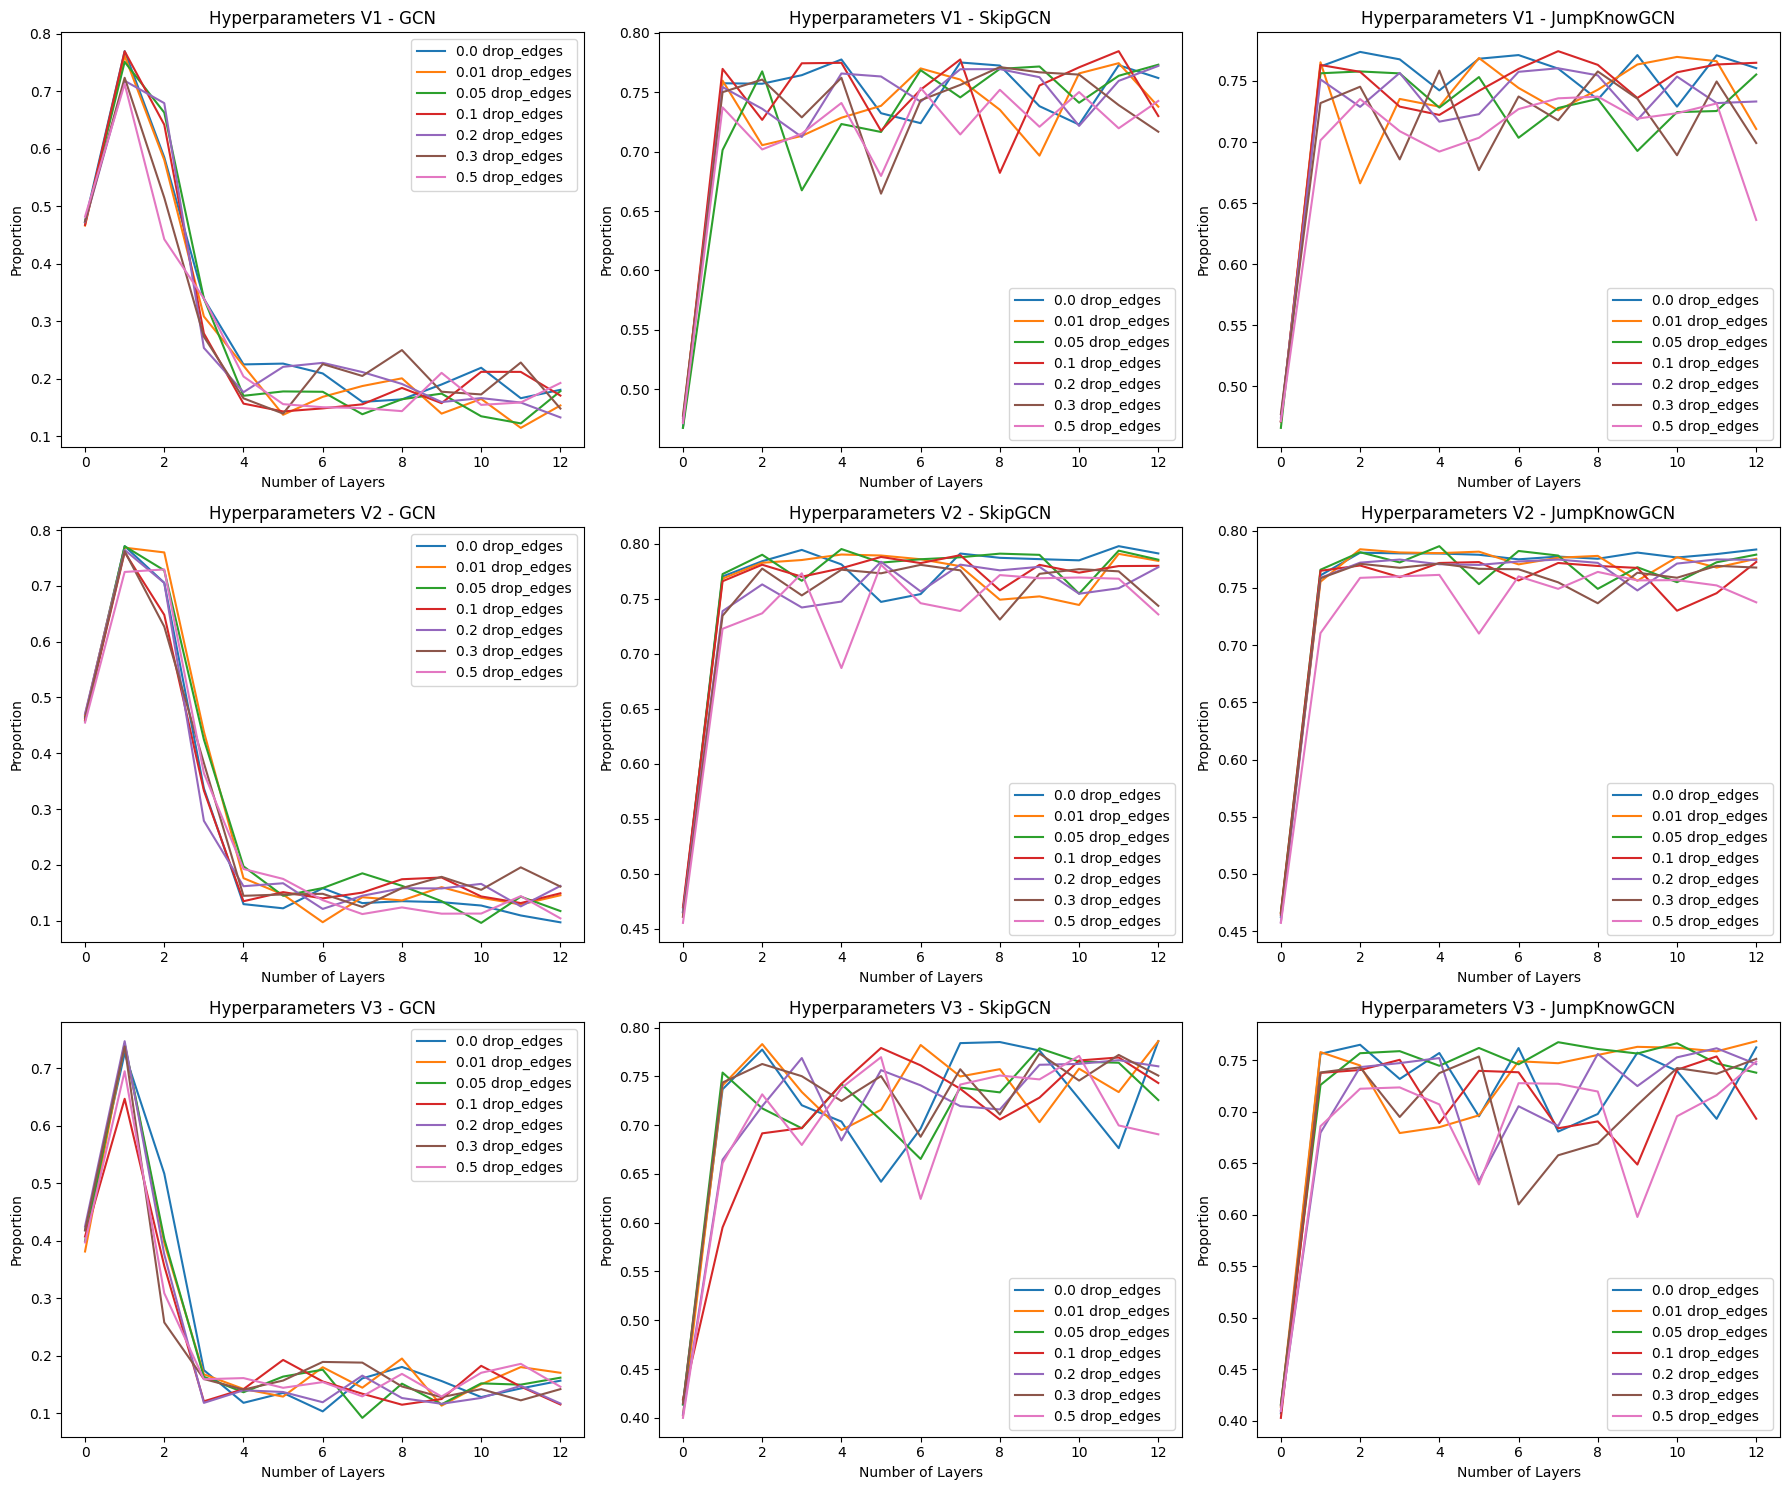

In [ ]:
# Create a plot with 3 subplots
fig, axs = plt.subplots(3, 3, figsize=(18, 15))

type_1 = [gcn_drop_edge, skip_drop_edge, jump_drop_edge]
type_2 = [cora_gcn_drop_edge, cora_skip_drop_edge, cora_jump_drop_edge]
type_3 = [new_gcn_drop_edge, new_skip_drop_edge, new_jump_drop_edge]
types = [type_1, type_2, type_3]

# Plotting GCN
k = 0
for t in types:
  for col in t[0].columns:
      axs[k,0].plot(t[0].index, t[0][col], label=f"{col}")
  axs[k,0].set_title(f"Hyperparameters V{k+1} - GCN")
  axs[k,0].set_xlabel("Number of Layers")
  axs[k,0].set_ylabel("Proportion")
  axs[k,0].legend()

  # Plotting SkipGCN
  for col in t[1].columns:
      axs[k,1].plot(t[1].index, t[1][col], label=f"{col}")
  axs[k,1].set_title(f"Hyperparameters V{k+1} - SkipGCN")
  axs[k,1].set_xlabel("Number of Layers")
  axs[k,1].set_ylabel("Proportion")
  axs[k,1].legend()

  # Plotting JumpKnowGCN
  for col in t[2].columns:
      axs[k,2].plot(t[2].index, t[2][col], label=f"{col}")
  axs[k,2].set_title(f"Hyperparameters V{k+1} - JumpKnowGCN")
  axs[k,2].set_xlabel("Number of Layers")
  axs[k,2].set_ylabel("Proportion")
  axs[k,2].legend()

  k += 1

# Show the plots
plt.tight_layout()
plt.show()

## Results

In [ ]:
gcn_drop_edge = pd.read_csv('GCN_drop_edges.csv')
gcn_rewire_edge = pd.read_csv('GCN_rewire_edges.csv')
gcn_shuffle_within = pd.read_csv('GCN_shuffle_within.csv')
gcn_shuffle_across = pd.read_csv('GCN_shuffle_across.csv')
skip_drop_edge = pd.read_csv('SkipGCN_drop_edges.csv')
skip_rewire_edge = pd.read_csv('SkipGCN_rewire_edges.csv')
skip_shuffle_within = pd.read_csv('SkipGCN_shuffle_within.csv')
skip_shuffle_across = pd.read_csv('SkipGCN_shuffle_across.csv')
jump_drop_edge = pd.read_csv('JumpKnowGCN_drop_edges.csv')
jump_rewire_edge = pd.read_csv('JumpKnowGCN_rewire_edges.csv')
jump_shuffle_within = pd.read_csv('JumpKnowGCN_shuffle_within.csv')
jump_shuffle_across = pd.read_csv('JumpKnowGCN_shuffle_across.csv')

In [ ]:
for i in [gcn_drop_edge, gcn_rewire_edge, gcn_shuffle_within, gcn_shuffle_across]:
  df = i.T
  df = df.round(3)
  df = df.applymap(lambda x: ('%.3f' % x).rstrip('0').rstrip('.'))
  df.columns = [str(l) for l in layers]
  df.index = [str(p) for p in props]
  print(df.to_latex())

In [ ]:
gcn_base = pd.concat([gcn_drop_edge['0.0 drop_edges'], cora_gcn_drop_edge['0.0 drop_edges'], new_gcn_drop_edge['0.0 drop_edges']], axis=1).mean(axis=1)
skip_base = pd.concat([skip_drop_edge['0.0 drop_edges'], cora_skip_drop_edge['0.0 drop_edges'], new_skip_drop_edge['0.0 drop_edges']], axis=1).mean(axis=1)
jump_base = pd.concat([jump_drop_edge['0.0 drop_edges'], cora_jump_drop_edge['0.0 drop_edges'], new_jump_drop_edge['0.0 drop_edges']], axis=1).mean(axis=1)

In [ ]:
gcn_base = gcn_drop_edge['0.0 drop_edges']
skip_base = skip_drop_edge['0.0 drop_edges']
jump_base = jump_drop_edge['0.0 drop_edges']
bases = [skip_base.iloc[1:], jump_base.iloc[1:]]

In [ ]:
def mean_highest_accuracy(df):
  column_means = df.mean()
  max_column = column_means.idxmax()
  return df[max_column]

In [ ]:
lst_skip = [skip_drop_edge.iloc[1:], cora_skip_drop_edge.iloc[1:], new_skip_drop_edge.iloc[1:]]
lst_jump = [jump_drop_edge.iloc[1:], cora_jump_drop_edge.iloc[1:], new_jump_drop_edge.iloc[1:]]
df_best_skip = pd.DataFrame({mean_highest_accuracy(x).name: mean_highest_accuracy(x) for x in lst_skip})
df_best_jump = pd.DataFrame({mean_highest_accuracy(x).name: mean_highest_accuracy(x) for x in lst_jump})

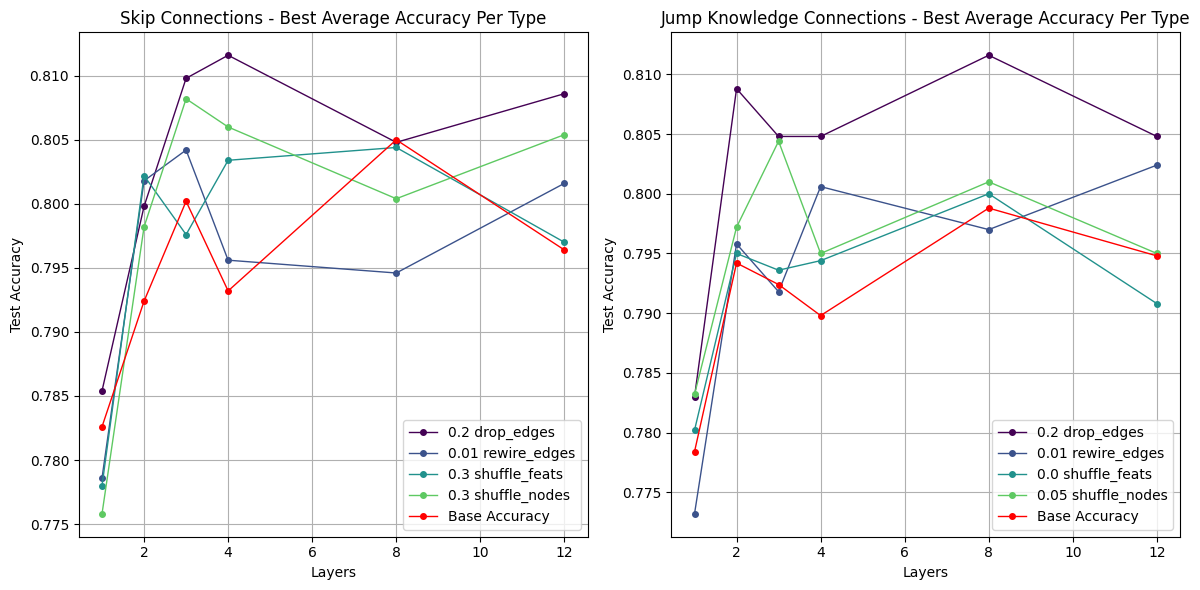

In [ ]:
model_titles = ["Skip Connections", "Jump Knowledge Connections"]
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
model_dfs = [df_best_skip, df_best_jump]
colormap = plt.cm.viridis
num_columns = len(df_best_skip.columns)
colors = [colormap(i / num_columns) for i in range(num_columns)]

for i, df in enumerate(model_dfs):
    ax = axs[i]
    for j, column in enumerate(df.columns):
      ax.plot(layers, df[column], label=column, marker='o', color=colors[j], linewidth=1, markersize=4, markeredgewidth=1)
    ax.plot(layers, bases[i], label='Base Accuracy', color='red', marker='o', linewidth=1, markersize=4, markeredgewidth=1)
    ax.set_xlabel('Layers')
    ax.set_ylabel('Test Accuracy')
    ax.set_title(f'{model_titles[i]} - Best Average Accuracy Per Type')
    ax.legend()
    ax.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
all_bases = [gcn_cora_norm, skip_cora_norm, jump_cora_norm]

In [ ]:
def plot_results_gcn_types(result_dfs: pd.DataFrame):
  model_titles = ["Drop Edges", "Rewire Edges", "Shuffle Vectors Within Nodes", "Shuffle Vectors Across Nodes"]
  fig, axs = plt.subplots(1, 4, figsize=(18, 6))
  colormap = plt.cm.viridis
   # Generate a list of colors for each column

  for i, df in enumerate(result_dfs):
    ax = axs[i]
    num_columns = len(df.columns)
    colors = [colormap(i / num_columns) for i in range(num_columns)]
    colors[0] = 'red'
    for j, column in enumerate(df.columns):
       ax.plot(df.index, df[column], label=column, marker='o', color=colors[j], linewidth=1, markersize=4, markeredgewidth=1)
    ax.set_xlabel('Layers')
    ax.set_ylabel('Values')
    ax.set_title(f"{model_titles[i]}")
    ax.legend()
    ax.grid(True)
  plt.tight_layout()
  # plt.title("GCN Accuracy Per Type for Cora Large Test/Val/Train Sets")
  plt.show()

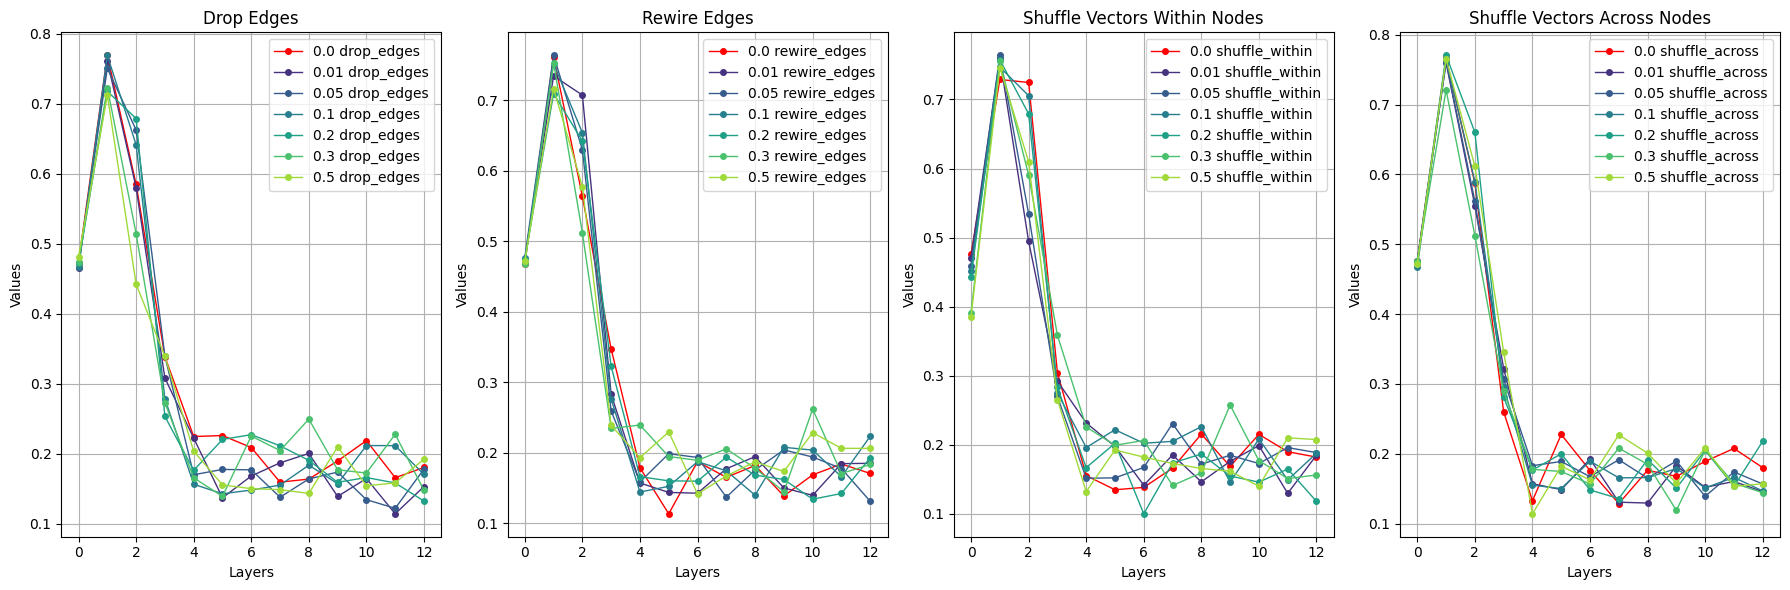

In [ ]:
plot_results_gcn_types([report_gcn_drop_edge, report_gcn_rewire_edge, report_gcn_shuffle_within, report_gcn_shuffle_across])

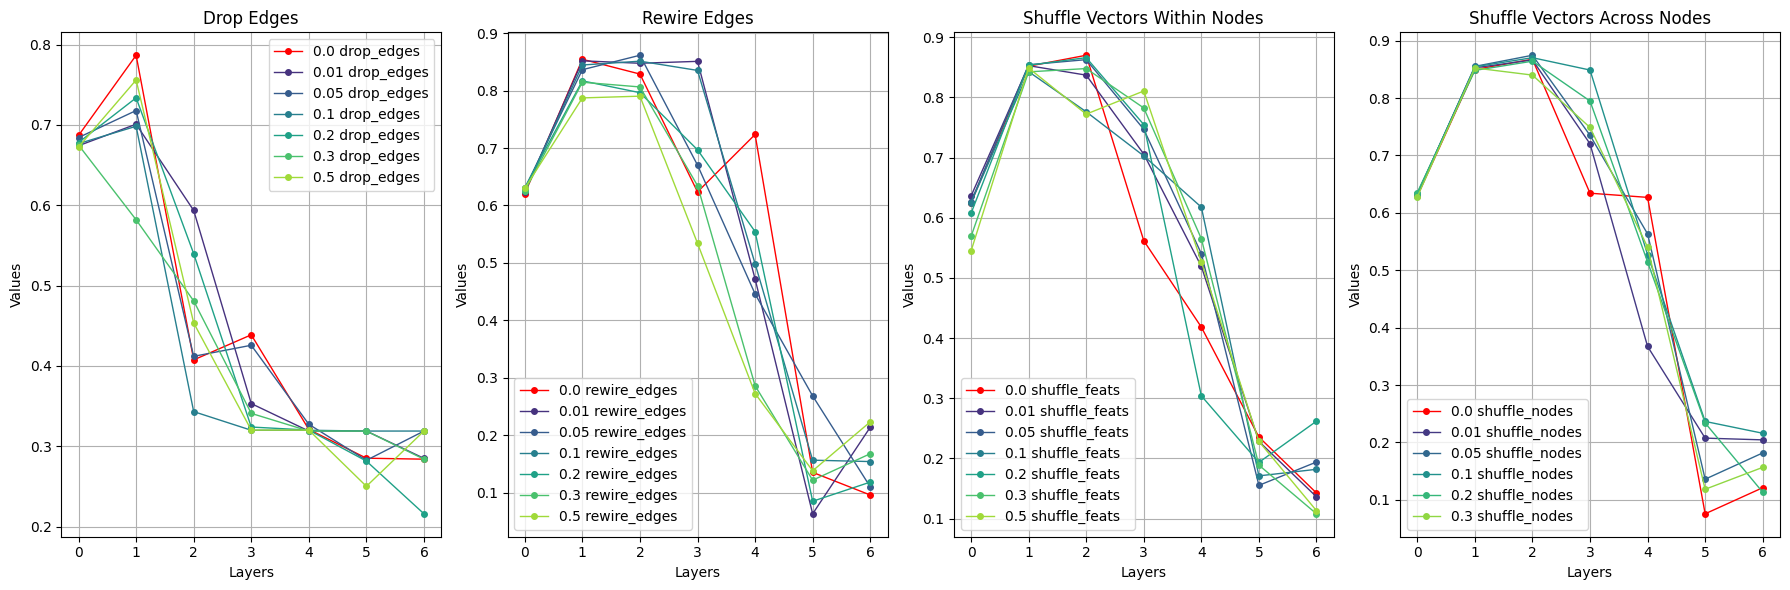

In [ ]:
plot_results_gcn_types([gcn_drop_edge_cora_split_norm, gcn_rewire_edge_cora_split_norm, gcn_shuffle_feats_cora_split_norm, gcn_shuffle_node_cora_split_norm])